# Imports

In [832]:
import requests
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm_notebook as tqdm # this is a fancy progress bar!
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Test one link

In [836]:
link = 'https://www.jobs.ch/en/vacancies/?page=1&term=Data%20Python'

In [837]:
# get the content from the link
response = requests.get(link, timeout = 15)

#check status code of the downloaded page
response.status_code

# parse the content with BeautifulSoup with the html.parser method
soup = BeautifulSoup(response.content, 'html.parser')

# Constructing the link

In [838]:
# Create the link (it is a better idea to constuct the especially link if you notice a specific pattern..)
link_first_part = 'https://www.jobs.ch'
link_mid_1_part = '/en/vacancies/?page='
link_mid_2_part = '&term='
keyword = 'Data Scientist'
keyword1 = 'Data Analyst'
keyword2 = 'Python Developer'
keyword3 = 'Data Engineer'
keyword4 = 'Data Manager'
keyword5 = 'Data Architect'
keyword6 = 'Big Data Analyst'
keyword7 = 'Data Python'

url= link_first_part + link_mid_1_part + '1' + link_mid_2_part + keyword7.replace(' ', '%20')
url

'https://www.jobs.ch/en/vacancies/?page=1&term=Data%20Python'

# Get the links
## Get the job links for one page

In [839]:
def get_links(link, job_links):
    response = requests.get(link, timeout = 15)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        job_link_content = soup.find_all('div', class_ = 'Box-sc-7ekkso-0 Position-b2pct5-0 Position__Relative-b2pct5-1 VacancySerpItem__ShadowBox-p4qu0m-0 hthPRS')
        for job_link in job_link_content:
            job_links.append(link_first_part + job_link.find('a', {'class': 'x--job-link t--job-link SearchVacancyResultsComponent__StyledVacancySerpItem-n25jij-0 dQDQbr'}).get('href'))
    else:
        print('Page down: {}'.format(link))
    return 

## Get the max pages

In [840]:
max_pages = int(soup.find('div', class_ = 'Div-v2w9ke-0 Flex-sc-4aokm-0 eykbax').get_text().split()[2])
max_pages

29

## Get all the pages

In [841]:
job_links = []

for page in tqdm(range(max_pages)):
    link = link_first_part + link_mid_1_part + str(page+1) + link_mid_2_part + keyword7
    get_links(link, job_links)
    sleep(0.6)
    


In [50]:
job_links[5]

'https://www.jobs.ch/en/vacancies/detail/9274909/?jobposition=1-6&source=vacancy_search'

In [51]:
#number of job links found
len(job_links)

572

# Get the page's content

In [52]:
# grab info from the correct tags
def scrape_content(soup):
    try:
        job_title = soup.find('div', {'class' : 'Div-v2w9ke-0 hPuVjT'}).find('h1').get('title')
    except:
        job_title = np.nan
        
    try:
        company_name = soup.find('div', class_ = 'Div-v2w9ke-0 cvwY').find('a').get('title')
    except:
        company_name = np.nan

    try:
        job_location = soup.find('span', class_ = 'Span-bhy2uh-0 Text__span-sc-1vcmz87-8 YbklG Span-bhy2uh-0 Text__span-sc-1vcmz87-8 Text-sc-1vcmz87-9 gdfMMD').get('title')
    except:
        job_location = np.nan
        
    try:
        occupation = soup.find('span', class_ = 'Span-bhy2uh-0 Badge-ndaeev-0 fylUor').get('title')
    except:
        occupation = np.nan
        
    try:
        job_rank = soup.find('span', class_ = 'Span-bhy2uh-0 Badge-ndaeev-0 krRxxu').next_sibling.get_text().replace('\xad', '')
    except:
        job_rank = np.nan

    try:
        job_content = soup.find('div', class_ = 'Div-v2w9ke-0 ijVstU vacancy-detail-content-box').get_text().strip()
    except:
        job_content = np.nan
        
    try:
        published = soup.find('span', class_ = 'Span-bhy2uh-0 Badge-ndaeev-0 krRxxu').get_text()
    except: 
        published = np.nan
    
    return job_title, company_name, job_location, occupation, job_rank, job_content, published


In [53]:
link = 'https://www.jobs.ch/en/vacancies/detail/9274909/?jobposition=1-6&source=vacancy_search'
response = requests.get(link, timeout = 15)
soup = BeautifulSoup(response.content, 'html.parser')
scrape_content(soup)

('IT Big Data Software Engineer',
 'UBS AG',
 'Opfikon',
 '80% – 100%',
 'Position with responsibilities',
 "200792BRIT Big Data Software EngineerYour role Are you a highly experienced, software developer? Do you want to design and build next generation business applications using the latest technologies? Are you confident at iteratively refining user requirements and removing any ambiguity? Do you like to be challenged and encouraged to learn and grow professionally? We are looking for Software Engineers to:*\tprovide technology solutions that will solve business problems and strengthen our position as digital leaders in financial services*\tanalyse business requirements with the business analysts in a small and dynamic team*\tdesign, plan and deliver production quality solutions using modern programming languages*\twrite automated tests as part of the software lifecycle*\tcontinuously improve and drive non-functional requirements of the platforms allowing sustainability and maintaina

# Scrape the job ads

In [850]:
columns = [
    'Keywords searched',
    'Job title',
    'Date parsed',
    'Company name',
    'Location',
    'Occupation',
    'Job rank',
    'Content',
    'Date published',
]

df = pd.DataFrame(columns = columns)
df

,Keywords searched,Job title,Date parsed,Company name,Location,Occupation,Job rank,Content,Date published


In [851]:
for job_ad in tqdm(job_links):
    response = requests.get(job_ad, timeout = 30)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
    
        #scrape the content
        job_title, company_name, job_location, occupation, job_rank, job_content, published = scrape_content(soup)

        # we append the data to the dataframe
        df = df.append({
        'Keywords searched': keyword7,
        'Job title': job_title,
        'Date parsed': datetime.now().date(),
        'Company name': company_name,
        'Location': job_location,
        'Occupation': occupation,
        'Job rank': job_rank,
        'Content': job_content,
        'Date published' : published}, ignore_index = True
        )
        sleep(0.8)
        
    else:
        print('Page down: {}'.format(job_ad))
    
df

,Keywords searched,Job title,Date parsed,Company name,Location,Occupation,Job rank,Content,Date published
0,Data Python,DevOps Python Developer,2019-11-17,MBA Michael Bailey Associates GmbH,Zurich,100%,Position with responsibilities,,08.11.2019
1,Data Python,Data Analyst (m/w/d),2019-11-17,Scintilla AG,Zuchwil,100%,Position with responsibilities,,11.11.2019
2,Data Python,Développeur/-euse Python orienté Web,2019-11-17,Arcanite Solutions Sàrl,Puidoux,80% – 100%,Employee,Arcanite est une jeune entreprise dynamique qu...,14.11.2019
3,Data Python,Data Engineer mit Flair für Analytics,2019-11-17,Noser Engineering AG,Winterthur,80% – 100%,Position with responsibilities,Data Engineer mit Flair für Analytics Möchtest...,15.11.2019
4,Data Python,Product Data Analyst (m/w),2019-11-17,Geberit AG,Rapperswil-Jona,100%,Employee,Product Data Analyst (m/w)Die fortschreitende ...,15.11.2019
5,Data Python,IT Big Data Software Engineer,2019-11-17,UBS AG,Opfikon,80% – 100%,Position with responsibilities,200792BRIT Big Data Software EngineerYour role...,15.11.2019
6,Data Python,Internship Big Data,2019-11-17,SIX,Zürich,100%,Employee,SIX operates the infrastructure underpinning t...,12.11.2019
7,Data Python,SOFTWARE ENGINEER PYTHON (M/W) 60-100%,2019-11-17,Signifikant Solutions AG,Root D4,60% – 100%,Position with responsibilities,,30.10.2019
8,Data Python,Data Analyst Prozessentwicklung CRM Kundendien...,2019-11-17,Die Schweizerische Post,Bern,80% – 100%,Employee,Data Analyst Prozessentwicklung CRM Kundendien...,13.11.2019
9,Data Python,Senior Database Engineer,2019-11-17,SIX,Zurich,100%,Position with responsibilities,SIX betreibt die schweizerische Finanzplatzinf...,16.11.2019


In [857]:
# save the dataframe to a csv file without the index
df.to_csv('jobs_ch_dataset7.csv', index=False)

In [854]:
df1=pd.read_csv('jobs_ch_dataset.csv')
df2=pd.read_csv('jobs_ch_dataset1.csv')
df3=pd.read_csv('jobs_ch_dataset2.csv')
df4=pd.read_csv('jobs_ch_dataset3.csv')
df5=pd.read_csv('jobs_ch_dataset4.csv')
df6=pd.read_csv('jobs_ch_dataset5.csv')
df7=pd.read_csv('jobs_ch_dataset6.csv')



In [548]:
sw=pd.read_csv('swiss.csv')
sw1 = sw[['city','admin']]
sw1.head()


,city,admin
0,Geneva,Genève
1,Zürich,Zürich
2,Basel,Basel-Stadt
3,Bern,Bern
4,Lausanne,Vaud


In [859]:
frames = [df1, df2, df3,df4, df5, df6,df7,df]
result = pd.concat(frames)
result.to_csv('jobs_ch_final.csv', index=False)
result.shape




(5188, 9)

In [864]:
res = result
res.head()

,Keywords searched,Job title,Date parsed,Company name,Location,Occupation,Job rank,Content,Date published
0,Data Scientist,Market Data Analyst,2019-11-16,Swiss Life Asset Managers,Zürich,80% – 100%,Employee,Swiss Life Asset Managers Arbeitspensum: 100%Z...,24.10.2019
1,Data Scientist,Data Scientist (Consultant),2019-11-16,PwC,Zürich,100%,Employee,Du arbeitest bei interessanten Projekten in Be...,28.10.2019
2,Data Scientist,Data Analyst Prozessentwicklung CRM Kundendien...,2019-11-16,Die Schweizerische Post,Bern,80% – 100%,Employee,Data Analyst Prozessentwicklung CRM Kundendien...,13.11.2019
3,Data Scientist,Senior Data Scientist - Forensics in Zurich,2019-11-16,EY,"Zurich, CH-ZH",100%,Employee,Senior Data Scientist - Forensics in ZurichWe ...,01.11.2019
4,Data Scientist,Product Data Analyst (m/w),2019-11-16,Geberit AG,Rapperswil-Jona,100%,Employee,Product Data Analyst (m/w)Die fortschreitende ...,15.11.2019



## How many jobs are shared between these categories?



In [804]:
jobs = res.groupby(['Keywords searched'])['Job title'].count()
jobs.head()


Keywords searched
Big Data Analyst     210
Data Analyst         474
Data Architect       230
Data Engineer        978
Data Manager        2077
Name: Job title, dtype: int64

Text(0.5, 1.0, 'Shared jobs')

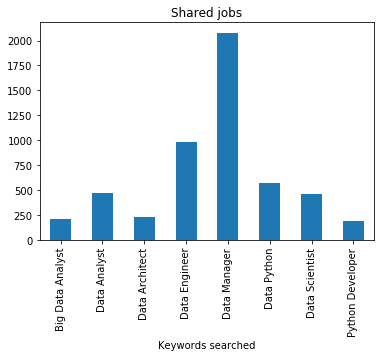

In [803]:
jobs.plot.bar()
plt.title("Shared jobs")

## How much the keywords: “Data Analyst” and “Big Data Analyst” overlap?

In [728]:
res1 = res[res['Keywords searched'] == "Data Analyst"]
res2 = res[res['Keywords searched'] == "Big Data Analyst"]
#print(res1.count())
#print(res2.count())
#print(res1["Job title"])
cnt1 = res1["Keywords searched"].count()
cnt2 = res2["Keywords searched"].count()
#print(cnt1)
#print(cnt2)
countsame = 0
for i in range(cnt1):
    for j in range(cnt2):
        cond = res1.iloc[i]["Job title"]== res2.iloc[j]["Job title"]
        cond = cond and (res1.iloc[i]["Company name"]== res2.iloc[j]["Company name"])
        cond = cond and (res1.iloc[i]["Location"]== res2.iloc[j]["Location"])
        cond = cond and (res1.iloc[i]["Occupation"]== res2.iloc[j]["Occupation"])
        cond = cond and (res1.iloc[i]["Job rank"]== res2.iloc[j]["Job rank"])
        cond = cond and (res1.iloc[i]["Content"]== res2.iloc[j]["Content"])
        cond = cond and (res1.iloc[i]["Date published"]== res2.iloc[j]["Date published"])
        if (cond):
            countsame += 1
print("The number of overlapings is %s"%(countsame))

The number of overlapings is 146




  ##  Are there some companies doing more hires than average?
  

   
   

In [729]:
company = res[pd.notnull(res['Company name'])]
company.head()

,Keywords searched,Job title,Date parsed,Company name,Location,Occupation,Job rank,Content,Date published
0,Data Scientist,Market Data Analyst,2019-11-16,Swiss Life Asset Managers,Zürich,80% – 100%,Employee,Swiss Life Asset Managers Arbeitspensum: 100%Z...,24.10.2019
1,Data Scientist,Data Scientist (Consultant),2019-11-16,PwC,Zürich,100%,Employee,Du arbeitest bei interessanten Projekten in Be...,28.10.2019
2,Data Scientist,Data Analyst Prozessentwicklung CRM Kundendien...,2019-11-16,Die Schweizerische Post,Bern,80% – 100%,Employee,Data Analyst Prozessentwicklung CRM Kundendien...,13.11.2019
3,Data Scientist,Senior Data Scientist - Forensics in Zurich,2019-11-16,EY,"Zurich, CH-ZH",100%,Employee,Senior Data Scientist - Forensics in ZurichWe ...,01.11.2019
4,Data Scientist,Product Data Analyst (m/w),2019-11-16,Geberit AG,Rapperswil-Jona,100%,Employee,Product Data Analyst (m/w)Die fortschreitende ...,15.11.2019


In [730]:
from pandas import Series
cnt = company["Company name"].count()
#print(cnt)
compdict = {}
for i in range(cnt):
    key = str(company.iloc[i]["Company name"])
    if key not in compdict:
        compdict[key] = 0
    else:   
        compdict[key] += 1

average = sum(compdict.values()) / float(len(compdict))

#print(average)
average = Series([compdict[k] for k in compdict]).mean()
print("the average hires is %s"%(round(average)))

output = pd.DataFrame()
for key in compdict:
    if compdict[key] > average:
         #print(key, compdict[key])   
         d ={'Company name': key, 'Number': compdict[key]}
         output = output.append(d, ignore_index=True)
     

    

the average hires is 6


In [740]:
avg = output.sort_values(by=['Number'], ascending=False)
avg.head(10)

,Company name,Number
11,Credit Suisse AG,266.0
17,F. Hoffmann-La Roche AG,183.0
24,Novartis AG,91.0
50,Swisscom (Schweiz) AG,73.0
0,PwC,64.0
41,Atos AG,59.0
40,Google Switzerland GmbH,54.0
37,Ernst & Young AG,53.0
1,EY,40.0
57,EPAM Systems (Switzerland) GmbH,36.0


Text(0.5, 1.0, 'Companies hire')

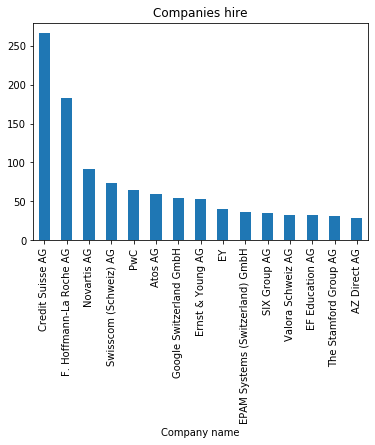

In [795]:
avg.iloc[:15].plot.bar(x='Company name', y='Number', legend = False)
plt.title('Companies hire')

In [745]:
dups_values = res.pivot_table(index=['Company name'], aggfunc='size')
dups_values = dups_values.dropna()
dups_values.sort_values().tail()


Company name
PwC                         65
Swisscom (Schweiz) AG       74
Novartis AG                 92
F. Hoffmann-La Roche AG    184
Credit Suisse AG           267
dtype: int64

In [865]:
g= res.groupby(['Company name']).count()['Job title'].sort_values(ascending=[False])
comp = g.dropna()
comp[comp > 6].head()

Company name
Credit Suisse AG           267
F. Hoffmann-La Roche AG    185
Novartis AG                 92
Swisscom (Schweiz) AG       75
PwC                         65
Name: Job title, dtype: int64

In [746]:
dups_values.mean()

6.595744680851064

## How many jobs are there in different Kantons?

In [868]:
sw = pd.read_csv('Swiss.csv')
sw = sw[['city', 'admin']]
citydict = {} # candton, city, number
for i in range(sw['city'].count()):
    city = str((sw['city'].iloc[i]))
    canton = str((sw['admin'].iloc[i]))
    citydict[city]= canton
#print(citydict)
result1 = res[pd.notnull(res['Location'])]
cnt = result1["Location"].count()
#print(cnt)
cantondict = {}
for i in range(cnt):
    city = str(result1.iloc[i]["Location"])
    if city in citydict:
        canton = citydict[city]
        if canton not in cantondict:
            cantondict[canton] = 0
        else:   
            cantondict[canton] += 1

out = pd.DataFrame()  
for canton in cantondict:
    if cantondict[canton]>0 :
        #print(canton, cantondict[canton] )
        d ={'Canton': canton, 'Number': cantondict[canton]}
        out = out.append(d, ignore_index=True)



                    Canton  Number
0                   Zürich  1030.0
3              Basel-Stadt   428.0
1                     Bern   123.0
9                     Vaud    89.0
5                      Zug    68.0
11                  Genève    36.0
4                   Aargau    30.0
6                Solothurn    29.0
8             Schaffhausen    26.0
7                 Fribourg    13.0
12                  Luzern    10.0
10                 Thurgau     8.0
2             Sankt Gallen     6.0
17              Graubünden     6.0
14                  Schwyz     4.0
15                  Ticino     4.0
13               Neuchâtel     3.0
16  Appenzell Ausserrhoden     3.0
18               Nidwalden     1.0


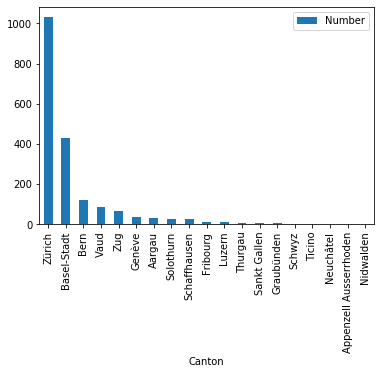

In [871]:
cantons = out.sort_values(by=['Number'], ascending=False)
print(cantons)
cantons.plot.bar(x='Canton', y='Number')

 ## Is “machine learning” keyword most often in data scientist or data analyst jobs?

In [748]:
res1 = result1[result1['Keywords searched'] == "Data Scientist"]
res2 = result1[result1['Keywords searched'] == "Data Analyst"]
cnt1 = res1["Keywords searched"].count()
cnt2 = res2["Keywords searched"].count()
#print(cnt1)
#print(cnt2)
countDS = 0
for i in range(cnt1):
    if (str(res1.iloc[i]["Content"]).upper().find("MACHINE LEARNING")>-1):
        countDS+=1
print("'machine learning' in Data Scientist - %s times"% (countDS))
      
countDA = 0
for i in range(cnt2):
    if (str(res2.iloc[i]["Content"]).upper().find("MACHINE LEARNING")>-1):
        countDA+=1
print("'machine learning' in Data Analyst - %s times"%(countDA))



'machine learning' in Data Scientist - 77 times
'machine learning' in Data Analyst - 51 times


 ## What is the distribution of most common keywords between and across categories?

In [687]:
content = res[pd.notnull(res['Content'])]
content

,Keywords searched,Job title,Date parsed,Company name,Location,Occupation,Job rank,Content,Date published
0,Data Scientist,Market Data Analyst,2019-11-16,Swiss Life Asset Managers,Zürich,80% – 100%,Employee,Swiss Life Asset Managers Arbeitspensum: 100%Z...,24.10.2019
1,Data Scientist,Data Scientist (Consultant),2019-11-16,PwC,Zürich,100%,Employee,Du arbeitest bei interessanten Projekten in Be...,28.10.2019
2,Data Scientist,Data Analyst Prozessentwicklung CRM Kundendien...,2019-11-16,Die Schweizerische Post,Bern,80% – 100%,Employee,Data Analyst Prozessentwicklung CRM Kundendien...,13.11.2019
3,Data Scientist,Senior Data Scientist - Forensics in Zurich,2019-11-16,EY,"Zurich, CH-ZH",100%,Employee,Senior Data Scientist - Forensics in ZurichWe ...,01.11.2019
4,Data Scientist,Product Data Analyst (m/w),2019-11-16,Geberit AG,Rapperswil-Jona,100%,Employee,Product Data Analyst (m/w)Die fortschreitende ...,15.11.2019
5,Data Scientist,Distribution Data Scientist Analyst,2019-11-16,Zurich Insurance Company,Zürich,100%,Position with responsibilities,Distribution Data Scientist Analyst Möchten...,29.10.2019
6,Data Scientist,Senior Quality Data Analyst,2019-11-16,Vorwerk International & Co. KmG,Wollerau,100%,Employee,"Senior Quality Data Analyst At Vorwerk, yo...",14.11.2019
7,Data Scientist,Data Analyst / Anwendungsentwickler (w/m),2019-11-16,Migros Bank AG,Wallisellen,80% – 100%,Employee,"Sie sind stolz, für eine führende schweizerisc...",12.11.2019
9,Data Scientist,Senior Data Scientist/Consultant,2019-11-16,AZ Direct AG,Cham ZG,80% – 100%,Position with responsibilities,Unsere Kunden in Dialog mit ihren Kunden zu br...,05.11.2019
10,Data Scientist,Data Analyst Produktdaten (m/w),2019-11-16,Magazine zum Globus AG,Zürich,100%,Position with responsibilities,Für unseren Hauptsitz in Zürich suchen wir per...,15.11.2019


In [852]:
dff= pd.Series(' '.join(content['Content']).lower().split()).value_counts()[:100]
dff

and              110488
the               59769
to                52355
in                50975
of                49041
a                 35285
with              27775
for               21968
you               20768
und               18799
our               17970
data              16860
is                14317
we                13846
as                13763
are               12493
experience        11773
or                11704
on                10495
an                10336
your              10308
business          10055
will               9792
team               9361
work               8468
be                 8028
der                6613
that               6457
at                 6317
development        6196
                  ...  
technology         2959
services           2859
analytics          2851
im                 2818
about              2804
•                  2787
customer           2756
develop            2755
environment        2743
well               2685
information     

In [792]:

from collections import Counter
keylist = list()
for x in res['Keywords searched']: 
    if x not in keylist:
        keylist.append(x)
#print(keylist) 
first = True
for key in keylist:
    keys = res[(res['Keywords searched']==key)]
    keys = keys[pd.notnull(keys['Content'])]
    if first:
        first = False
        series= pd.Series(''.join(keys['Content']).lower().split()).value_counts()[:100]
        seriesdct = dict(series)
    else:
        ser = pd.Series(''.join(keys['Content']).lower().split()).value_counts()[:100]
        serdct = dict(ser)
        seriesdct = { item : seriesdct[item]+serdct[item] for item in seriesdct if item in serdct and len(item)>5}

print(seriesdct)

result  = pd.Series(seriesdct, index=seriesdct.keys())
result.index.name = 'Keyword'
print(result)




{'experience': 11773, 'development': 6193, 'business': 9915, 'knowledge': 4983, 'skills': 5398, 'original': 4596, 'strong': 4389, 'working': 5531, 'support': 4909, 'management': 6159, 'display': 3504, 'solutions': 4111}
Keyword
experience     11773
development     6193
business        9915
knowledge       4983
skills          5398
original        4596
strong          4389
working         5531
support         4909
management      6159
display         3504
solutions       4111
dtype: int64


Text(0.5, 1.0, 'Keywords in categories')

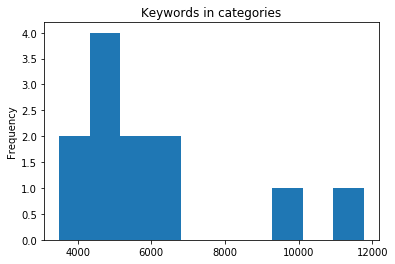

In [793]:
result.plot.hist()
plt.title('Keywords in categories')

In [853]:
dff1= pd.Series(' '.join(content['Content']).lower().split()).value_counts()


Text(0.5, 1.0, 'Keywords in categories')

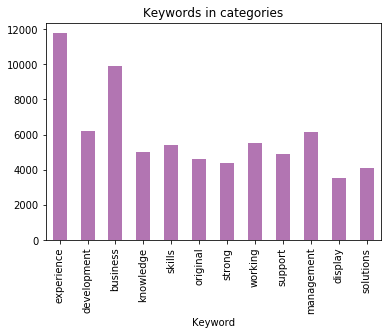

In [790]:
result.plot.bar(color = (0.5,0.1,0.5,0.6))
plt.title('Keywords in categories')

Text(0.5, 1.0, 'Keywords in categories')

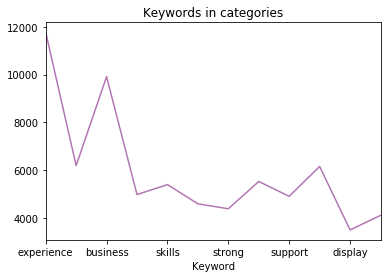

In [789]:
result.plot(x='Keyword', color = (0.5,0.1,0.5,0.6))
plt.title('Keywords in categories')